# Imports and program variables


In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
import pandas as pd

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

from time_series_dataset_loader import TimeSeriesDatasetLoader

from sklearn.model_selection import train_test_split # to split dataset into train and test
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.
/home/moutinho/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/moutinho/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/moutinho/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/moutinho/.local/lib/python3.6/site-packages/tensorflo

In [21]:
DATASET_PATH = '../datasets/MFCC'

## Setting up train and test datasets

In [22]:
dataset_loader = TimeSeriesDatasetLoader(DATASET_PATH)
X, y = dataset_loader.get_dataset()

In [23]:
X = np.asarray(X)
y = np.asarray(y)

In [24]:
# Completing with zeros
max_len = len(X[0])
for row in X:
        if len(row) > max_len:
            max_len = len(row)

X = pad_sequences(X, maxlen=max_len, padding='post')

In [25]:
# See X and y details
print(X[:2])
print(X.shape)

print(y[:3])
print(y.shape)

[[[ 0  0 -7 ...  0  2 -2]
  [ 1  0 -7 ...  0  5 -1]
  [ 2  0 -7 ...  1  1 -1]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0 11 ...  0  0 -9]
  [ 1  0 13 ... -1  0 -6]
  [ 2  0 11 ... -6  0 -5]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]]
(1066, 543, 16)
[3 0 1]
(1066,)


In [26]:
# Split the dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

print("\nX_train:\n")
print(X_train[0][0])
print(X_train.shape)

print("\nX_test:\n")
print(X_test[0][0])
print(X_test.shape)

print("\ny_train:\n")
print(y_train[:3])
print(y_train.shape)

print("\ny_test:\n")
print(y_test[:3])
print(y_test.shape)


X_train:

[  0   0   8  -2   7  -2  10   5  -3  -6  16  -5  -1  -4   1 -10]
(746, 543, 16)

X_test:

[  0   0  -4   0   4   9   2   5   2  13   4   9   8  -1   5 -25]
(320, 543, 16)

y_train:

[0 2 2]
(746,)

y_test:

[1 5 4]
(320,)


In [27]:
# Create categorical matrices
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [28]:
num_rows = X[0].shape[0]
num_columns = X[0].shape[1]
num_channels = 1

X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

print("\nX_train:\n")
print(X_train[0][0])
print(X_train.shape)

print("\nX_test:\n")
print(X_test[0][0])
print(X_test.shape)


X_train:

[[  0]
 [  0]
 [  8]
 [ -2]
 [  7]
 [ -2]
 [ 10]
 [  5]
 [ -3]
 [ -6]
 [ 16]
 [ -5]
 [ -1]
 [ -4]
 [  1]
 [-10]]
(746, 543, 16, 1)

X_test:

[[  0]
 [  0]
 [ -4]
 [  0]
 [  4]
 [  9]
 [  2]
 [  5]
 [  2]
 [ 13]
 [  4]
 [  9]
 [  8]
 [ -1]
 [  5]
 [-25]]
(320, 543, 16, 1)


## Building and Compiling Model

In [29]:
# Construct model 1
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(7, activation='softmax'))

In [34]:
# top-k category accuracy
import functools
import keras
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',top3_acc])

In [35]:
# Define bath and epochs
batch_size = 128
epochs = 100

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.0000001)
mcp_save = ModelCheckpoint('../models/model_checkpoints/default.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, y_test), callbacks=[mcp_save, lr_reduce])

Train on 746 samples, validate on 320 samples
Epoch 1/100
746/746 [==============================] - 7s 10ms/step - loss: 2.1288 - accuracy: 0.1622 - top3_acc: 0.4571 - val_loss: 1.9927 - val_accuracy: 0.1875 - val_top3_acc: 0.4750
Epoch 2/100
746/746 [==============================] - 7s 10ms/step - loss: 2.0242 - accuracy: 0.1609 - top3_acc: 0.4625 - val_loss: 1.9706 - val_accuracy: 0.1531 - val_top3_acc: 0.4969
Epoch 3/100
746/746 [==============================] - 8s 10ms/step - loss: 1.9864 - accuracy: 0.1662 - top3_acc: 0.4879 - val_loss: 1.9606 - val_accuracy: 0.1625 - val_top3_acc: 0.4938
Epoch 4/100
746/746 [==============================] - 7s 9ms/step - loss: 1.9663 - accuracy: 0.1582 - top3_acc: 0.4745 - val_loss: 1.9551 - val_accuracy: 0.1781 - val_top3_acc: 0.5281
Epoch 5/100
746/746 [==============================] - 7s 9ms/step - loss: 1.9629 - accuracy: 0.1917 - top3_acc: 0.4893 - val_loss: 1.9413 - val_accuracy: 0.1594 - val_top3_acc: 0.5156
Epoch 6/100
746/746 [=====

Epoch 45/100
746/746 [==============================] - 7s 10ms/step - loss: 1.6883 - accuracy: 0.3137 - top3_acc: 0.6997 - val_loss: 1.7717 - val_accuracy: 0.2344 - val_top3_acc: 0.6750
Epoch 46/100
746/746 [==============================] - 8s 10ms/step - loss: 1.6584 - accuracy: 0.3244 - top3_acc: 0.7265 - val_loss: 1.7861 - val_accuracy: 0.2344 - val_top3_acc: 0.6375
Epoch 47/100
746/746 [==============================] - 9s 12ms/step - loss: 1.6735 - accuracy: 0.3150 - top3_acc: 0.7346 - val_loss: 1.8125 - val_accuracy: 0.2156 - val_top3_acc: 0.6281
Epoch 48/100
746/746 [==============================] - 8s 11ms/step - loss: 1.6642 - accuracy: 0.3445 - top3_acc: 0.7399 - val_loss: 1.9221 - val_accuracy: 0.1844 - val_top3_acc: 0.5188
Epoch 49/100
746/746 [==============================] - 7s 10ms/step - loss: 1.6667 - accuracy: 0.3231 - top3_acc: 0.7426 - val_loss: 1.8140 - val_accuracy: 0.2094 - val_top3_acc: 0.6500
Epoch 50/100
746/746 [==============================] - 8s 11ms/s

Epoch 89/100
746/746 [==============================] - 10s 14ms/step - loss: 1.4674 - accuracy: 0.4236 - top3_acc: 0.8351 - val_loss: 1.8211 - val_accuracy: 0.2469 - val_top3_acc: 0.6375
Epoch 90/100
746/746 [==============================] - 10s 13ms/step - loss: 1.4860 - accuracy: 0.4021 - top3_acc: 0.8056 - val_loss: 1.8963 - val_accuracy: 0.2344 - val_top3_acc: 0.6187
Epoch 91/100
746/746 [==============================] - 9s 12ms/step - loss: 1.4695 - accuracy: 0.4303 - top3_acc: 0.8231 - val_loss: 1.8047 - val_accuracy: 0.2469 - val_top3_acc: 0.6750
Epoch 92/100
746/746 [==============================] - 9s 12ms/step - loss: 1.4502 - accuracy: 0.4357 - top3_acc: 0.8177 - val_loss: 1.8118 - val_accuracy: 0.2594 - val_top3_acc: 0.6313
Epoch 93/100
746/746 [==============================] - 8s 10ms/step - loss: 1.4678 - accuracy: 0.4223 - top3_acc: 0.8123 - val_loss: 1.8134 - val_accuracy: 0.2313 - val_top3_acc: 0.6906
Epoch 94/100
746/746 [==============================] - 7s 10ms

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 95, 15, 32)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 7, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 7, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 6, 64)         8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 3, 64)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 3, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 2, 128)       

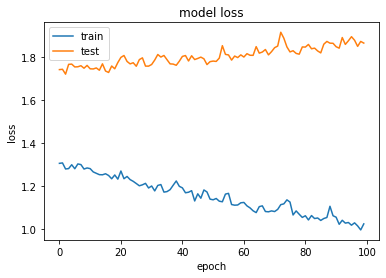

In [20]:
import matplotlib.pyplot as plt

# Model Summary

model.summary()

# PLT History info
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()